In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
path = "1.png"
gauss_blur_sigma = 1.5

## First try

In [3]:
def show_image(img):
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def show_grayscale_image(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

def convolution(img, kernel):
    grayscale = False
    if img.ndim == 2:
        grayscale = True
        img = img.reshape((img.shape[0], img.shape[1], 1))
    height, width, channels = img.shape
    kernel_h, kernel_w = kernel.shape
    output_w = width - kernel_w + 1
    output_h = height - kernel_h + 1
    result = np.zeros(img.shape, dtype=np.uint8)
    
    left_padding_size = (width - output_w) // 2
    top_padding_size = (height - output_h) // 2
    for channel in range(channels):
        for i in range(output_h):
            for j in range(output_w):
                element = np.sum(np.multiply(kernel, img[i:i+kernel_h, j:j+kernel_w, channel]))
                if (element > 255):
                    element = 255
                result[i + top_padding_size,j + left_padding_size,channel] = element
    
    if grayscale:
        result = result.reshape((result.shape[0], result.shape[1]))
    return result

def gauss_pdf(sigma, x, y):
    return np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)

def gauss_kernel(sigma=1, size=5):
    kernel = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            kernel[i, j] = gauss_pdf(sigma, i - size // 2, j - size // 2)

    return kernel

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convolution(img, Kx)
    Iy = convolution(img, Ky)
    
    G = np.hypot(Ix, Iy)
    magnitude = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (magnitude, theta)

def non_max_suppression(magnitude, theta):
    M, N = magnitude.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                    Z[i,j] = magnitude[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

def round_angle(angle):
    # Angle is rounded to one of four angles (0, PI/4, PI/2 and 3PI/4)
    angle = (angle + np.pi) % np.pi
    if angle < np.pi / 8 or angle > 7 * np.pi / 8:
        return 0
    if angle < np.pi / 8 + np.pi / 4:
        return np.pi / 4
    if angle < np.pi / 8 + np.pi / 2:
        return np.pi / 2
    return 3 * np.pi / 4

def non_max_suppression2(magnitude, theta):
    width, height = magnitude.shape
    result = np.zeros(magnitude.shape)

    for i in range(1, width - 1):
        for j in range(1, height - 1):
            angle = round_angle(theta[i, j])
            m = magnitude[i, j]

            if angle == 0:
                # Check east-west directions neighbours magnitude
                m1 = magnitude[i, j + 1]
                m2 = magnitude[i, j - 1]

            if angle == np.pi / 4:
                # Check north east and south west directions
                m1 = magnitude[i + 1, j - 1]
                m2 = magnitude[i - 1, j + 1]
            elif angle == np.pi / 2:
                # Check north and south directions
                m1 = magnitude[i + 1, j]
                m2 = magnitude[i - 1, j]
            else:
                # Check north west and south-east
                m1 = magnitude[i - 1, j - 1]
                m2 = magnitude[i + 1, j + 1]

            if m > m1 and m > m2:
                result[i, j] = m
            else:
                # Magnitude is suppressed
                result[i, j] = 0

    return result

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):

    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass

    return img

In [4]:
img = cv2.imread(path)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

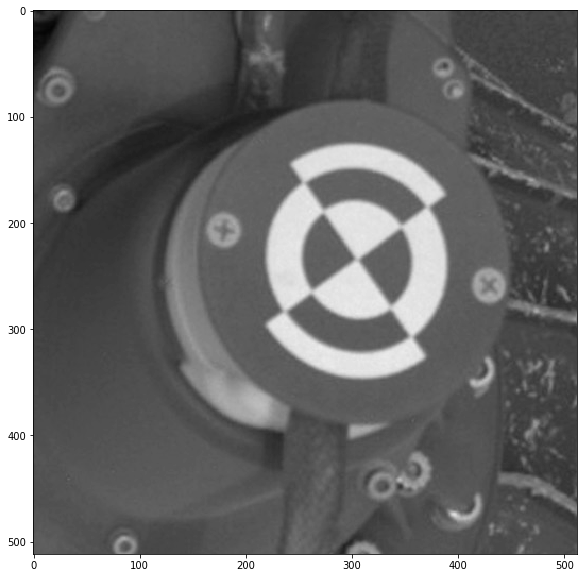

In [5]:
show_grayscale_image(gray_img)

In [6]:
filtered_img = convolution(gray_img, gauss_kernel(gauss_blur_sigma))

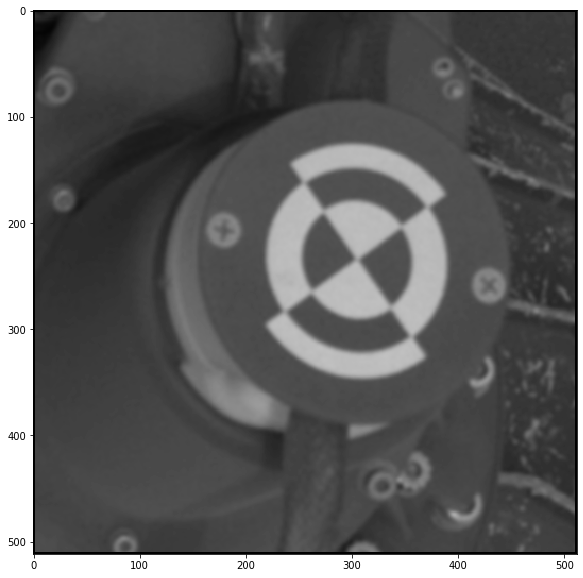

In [7]:
show_grayscale_image(filtered_img)

In [8]:
magnitude, theta = sobel_filters(filtered_img)

In [9]:
suppress_magnitude = non_max_suppression(magnitude, theta)

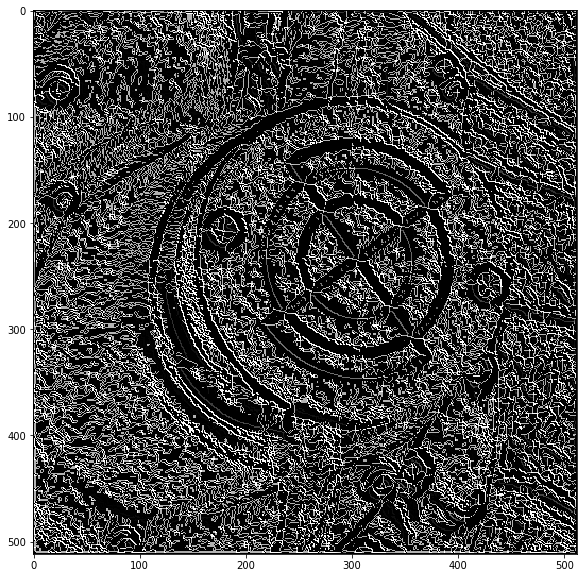

In [10]:
show_grayscale_image(suppress_magnitude)

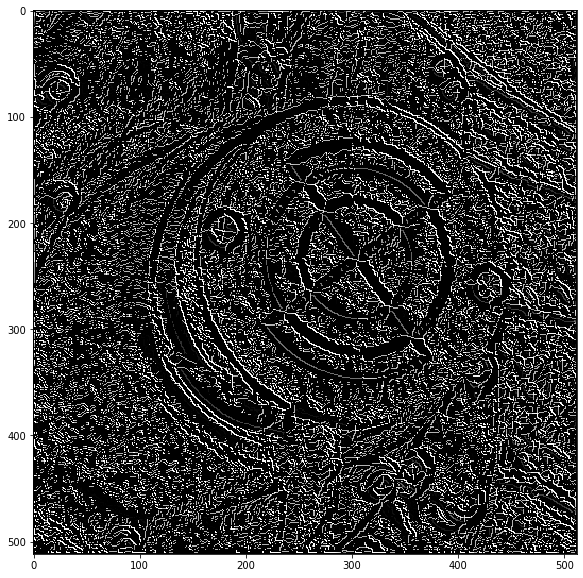

In [11]:
suppressed_magnitude2 = non_max_suppression2(magnitude, theta)
show_grayscale_image(suppressed_magnitude2)

In [12]:
suppress_magnitude_threshold, weak, strong = threshold(suppress_magnitude)

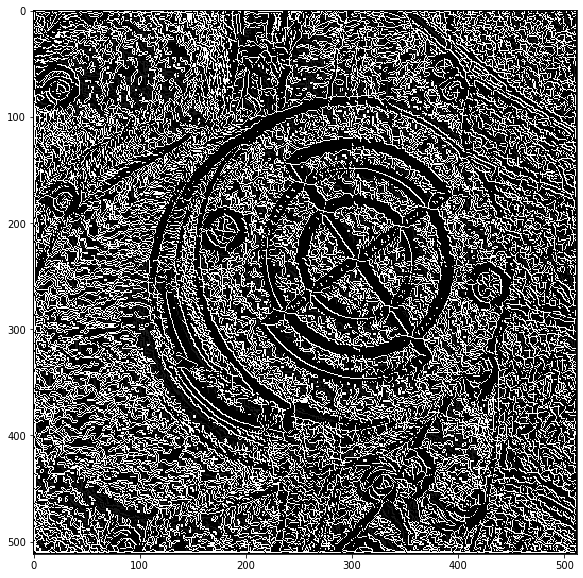

In [13]:
show_grayscale_image(suppress_magnitude_threshold)

In [14]:
result = hysteresis(suppress_magnitude_threshold, weak, strong)

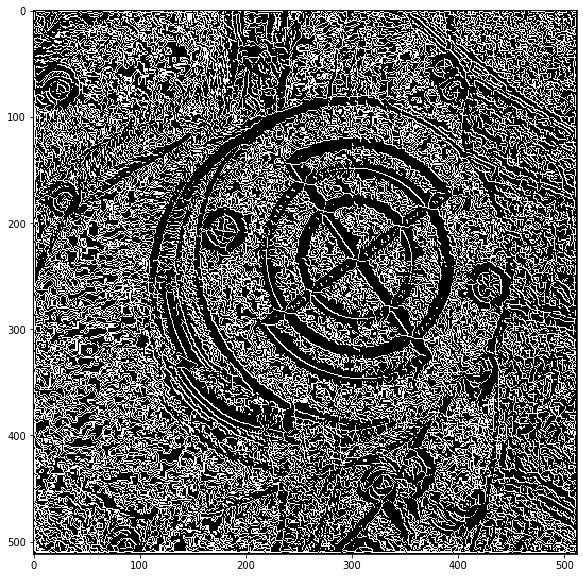

In [15]:
show_grayscale_image(result)

## Second try

In [16]:
from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final

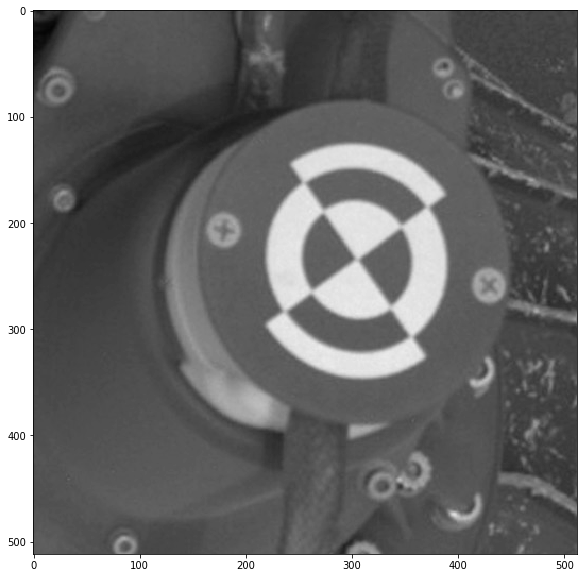

In [17]:
show_grayscale_image(gray_img)

In [20]:
detector = cannyEdgeDetector([gray_img], sigma=1.4, kernel_size=5, lowthreshold=0.09, highthreshold=0.17, weak_pixel=100)

In [21]:
imgs_final = detector.detect()

[array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0, 255, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)]

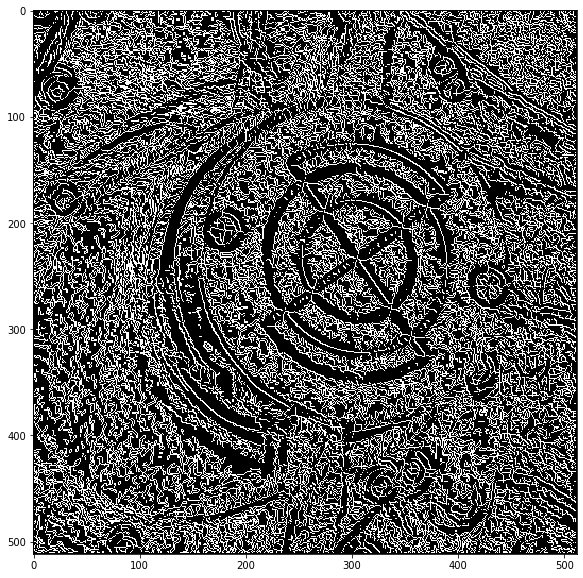

In [23]:
show_grayscale_image(imgs_final[0])

## Third try

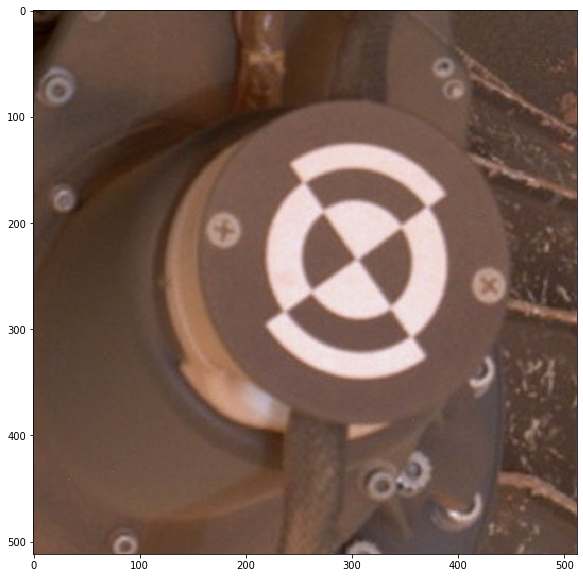

In [24]:
show_image(img)

In [26]:
image_smoothed = convolution(img, gauss_kernel(gauss_blur_sigma))
def sobel_filters(im):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    channels = im.shape[2]
    Ix = np.sum(convolution(im, Kx), axis=2) / channels
    Iy = np.sum(convolution(im, Ky), axis=2) / channels

    G = np.hypot(Ix, Iy)

    magnitude = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (magnitude, theta)

magnitude, theta = sobel_filters(image_smoothed)

def round_angle(angle):
    # Angle is rounded to one of four angles (0, PI/4, PI/2 and 3PI/4)
    angle = (angle + np.pi) % np.pi
    if angle < np.pi / 8 or angle > 7 * np.pi / 8:
        return 0
    if angle < np.pi / 8 + np.pi / 4:
        return np.pi / 4
    if angle < np.pi / 8 + np.pi / 2:
        return np.pi / 2
    return 3 * np.pi / 4

def non_max_suppression(magnitude, theta):
    width, height = magnitude.shape
    result = np.zeros(magnitude.shape)

    for i in range(1, width - 1):
        for j in range(1, height - 1):
            angle = round_angle(theta[i, j])
            m = magnitude[i, j]

            if angle == 0:
                # Check east-west directions neighbours magnitude
                m1 = magnitude[i, j + 1]
                m2 = magnitude[i, j - 1]

            if angle == np.pi / 4:
                # Check north east and south west directions
                m1 = magnitude[i + 1, j - 1]
                m2 = magnitude[i - 1, j + 1]
            elif angle == np.pi / 2:
                # Check north and south directions
                m1 = magnitude[i + 1, j]
                m2 = magnitude[i - 1, j]
            else:
                # Check north west and south-east
                m1 = magnitude[i - 1, j - 1]
                m2 = magnitude[i + 1, j + 1]

            if m > m1 and m > m2:
                result[i, j] = m
            else:
                # Magnitude is suppressed
                result[i, j] = 0

    return result


suppressed_magnitude = non_max_suppression(magnitude, theta)

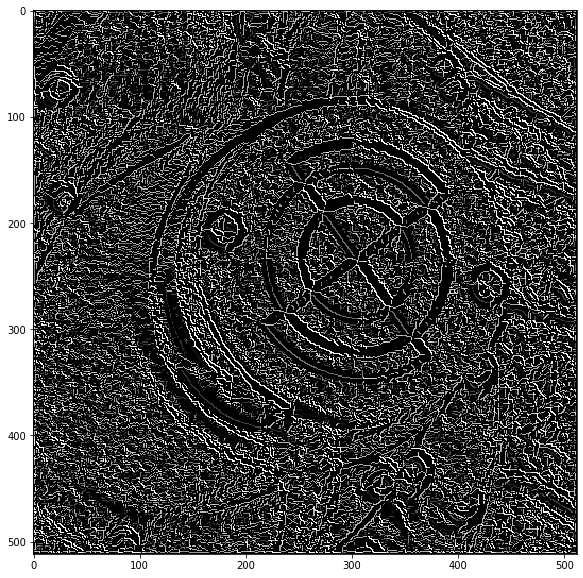

In [28]:
show_grayscale_image(suppressed_magnitude)